<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import sys

In [2]:
!pip install --upgrade pip -q

In [3]:
!pip install -U scikit-learn -q

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^


In [4]:
!{sys.executable} -m pip install spacy -q

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^


In [5]:
!{sys.executable} -m spacy download en_core_web_sm -q

DEPRECATION: https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.2.0/en_core_web_sm-3.2.0-py3-none-any.whl#egg=en_core_web_sm==3.2.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
import pandas as pd
import re
import spacy
import nltk
import seaborn as sn
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
import sklearn.svm as svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
RANDOM_STATE=42

In [9]:
def lemmatize_text(text):
    doc = nlp(text)
    return(re.sub(r'[^a-zA-Z ]', ' '," ".join([token.lemma_ for token in doc])))

## Подготовка

In [10]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])

In [11]:
data.duplicated().sum()

0

In [12]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [13]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

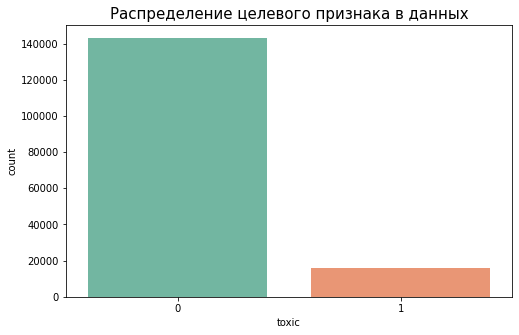

In [14]:
sn.set_palette('Set2')
plt.subplots(figsize=(8, 5))
plt.title(label=f'Распределение целевого признака в данных' , fontsize=15)
sn.countplot(data=data, x='toxic');

In [15]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [16]:
tqdm.pandas()

In [17]:
data['lemm_text'] = data['text'].progress_apply(lemmatize_text)

100%|██████████| 159292/159292 [17:04<00:00, 155.46it/s]


In [18]:
stop_words = set(stopwords.words('english'))

In [19]:
vectorizer = TfidfVectorizer(stop_words=list(stop_words))

**Промежуточный вывод по подготовке данных**

* Дубликатов в данных не было
* Пропусков в данных не было
* Наблюдается дисбаланс целевого признака, который будет учтен при разделении данных на обучающие и тестовые

## Обучение

In [20]:
train_X_pipe, test_X_pipe, train_y_pipe, test_y_pipe = train_test_split(
    data['lemm_text'],
    data['toxic'],
    test_size=0.2,
    random_state=42,
    stratify = data['toxic']
)

In [21]:
text_pipe = Pipeline([
        ('vector', TfidfVectorizer(stop_words=list(stop_words))),
        ('models', None)
])

In [22]:
param_grid = [
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(5,15),
        'models__max_features': range(2,5)
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': [0.01, 0.1, 1, 10]
    },
    {
        'models': [svm.SVC(kernel='linear')]
    }
]

In [23]:
grid_search = GridSearchCV(
    text_pipe, 
    param_grid,
    cv=3,
    scoring = 'f1',  
    n_jobs=-1,
    verbose = 2
)

In [24]:
grid_search.fit(train_X_pipe, train_y_pipe)

Fitting 3 folds for each of 35 candidates, totalling 105 fits
[CV] END models=DecisionTreeClassifier(random_state=42), models__max_depth=5, models__max_features=2; total time=   5.2s
[CV] END models=DecisionTreeClassifier(random_state=42), models__max_depth=5, models__max_features=2; total time=   5.2s
[CV] END models=DecisionTreeClassifier(random_state=42), models__max_depth=5, models__max_features=2; total time=   5.1s
[CV] END models=DecisionTreeClassifier(random_state=42), models__max_depth=5, models__max_features=3; total time=   5.3s
[CV] END models=DecisionTreeClassifier(random_state=42), models__max_depth=5, models__max_features=3; total time=   5.3s
[CV] END models=DecisionTreeClassifier(random_state=42), models__max_depth=5, models__max_features=3; total time=   5.3s
[CV] END models=DecisionTreeClassifier(random_state=42), models__max_depth=5, models__max_features=4; total time=   5.3s
[CV] END models=DecisionTreeClassifier(random_state=42), models__max_depth=5, models__max_f

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vector',
                                        TfidfVectorizer(stop_words=['an',
                                                                    "mightn't",
                                                                    'and',
                                                                    'she',
                                                                    "weren't",
                                                                    'no',
                                                                    'just',
                                                                    "aren't",
                                                                    'about',
                                                                    'after',
                                                                    'will',
                                                                    "doesn't",
                                                                    'than',
                                                                    'my', 'why',
                                                                    'all',
                                                                    'below',
                                                                    "you'd",
                                                                    'during',
                                                                    'had',
                                                                    'those',
                                                                    "hadn't",
                                                                    'they',
                                                                    'while',
                                                                    'ourselves',
                                                                    'which',
                                                                    'a', 'its',
                                                                    'it',
                                                                    'some', ...])),
                                       ('models', None)]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeClassifier(random_state=42)],
                          'models__max_depth': range(5, 15),
                          'models__max_features': range(2, 5)},
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': [0.01, 0.1, 1, 10]},
                         {'models': [SVC(kernel='linear')]}],
             scoring='f1', verbose=2)

In [25]:
print ('Метрика лучшей модели на кроссвалидации:', grid_search.best_score_)

Метрика лучшей модели на кроссвалидации: 0.7703212668779358


**Необходимый порог метрики на кроссвалидации достигнут. Его показала модель LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')**

In [26]:
grid_pred = grid_search.best_estimator_.predict(test_X_pipe)

In [27]:
f1_score(test_y_pipe, grid_pred)

0.7763920604250835

## Выводы

**Линейная регрессия показала себя лучше, чем модель деревьев или опорных векторов в данном задании по классификации текста на предмет его токсичности**

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны